In [1]:
import dataloader2
import numpy as np
import os
len(dataloader2.good_sids)

37

In [2]:
np.random.seed(42)
train_sids = np.random.choice(dataloader2.good_sids, 30)
test_sids = [i for i in dataloader2.good_sids if i not in train_sids]

In [12]:
len(train_sids), len(test_sids)

(30, 16)

In [3]:
from models import model1min

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 14, 32)         800       
                                                                 
 max_pooling2d (MaxPooling2  (None, 1, 4, 32)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 2112 (8.25 KB)
Trainable params: 2112 (8.25 KB)
Non-trainable params: 0 (0.00 Byte)
________________________

In [4]:
model1min.is_trained()

True

In [17]:
import importlib
importlib.reload(model1min)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 1, 14, 32)         800       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 1, 4, 32)          0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 10)                1290      
                                                                 
 dense_7 (Dense)             (None, 2)                 22        
                                                                 
Total params: 2112 (8.25 KB)
Trainable params: 2112 (8.25 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

<module 'models.model1min' from 'd:\\Projects\\ChildMindSleep\\models\\model1min.py'>

In [5]:
submission_files = dataloader2.test_sids_files()
submission_files

['data\\test_sids\\038441c925bb.parquet',
 'data\\test_sids\\03d92c9f6f8a.parquet',
 'data\\test_sids\\0402a003dae9.parquet']

In [6]:
xAndIndex = [model1min.getXandIndex(f) for f in submission_files]

In [15]:
xAndIndex[0][1]

Index([ 12,  13,  14,  15,  16,  17,  18,  19,  20,  21,
       ...
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137],
      dtype='int64', length=126)

In [19]:
import pandas as pd
dfs = [pd.read_parquet(f) for f in submission_files]
for df in dfs:
    df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

In [16]:
preds = [model1min.model(x) for (x,_) in xAndIndex]
sleeps = [i[:,1] for i in preds]

In [18]:
sleeps[0].shape

TensorShape([126])

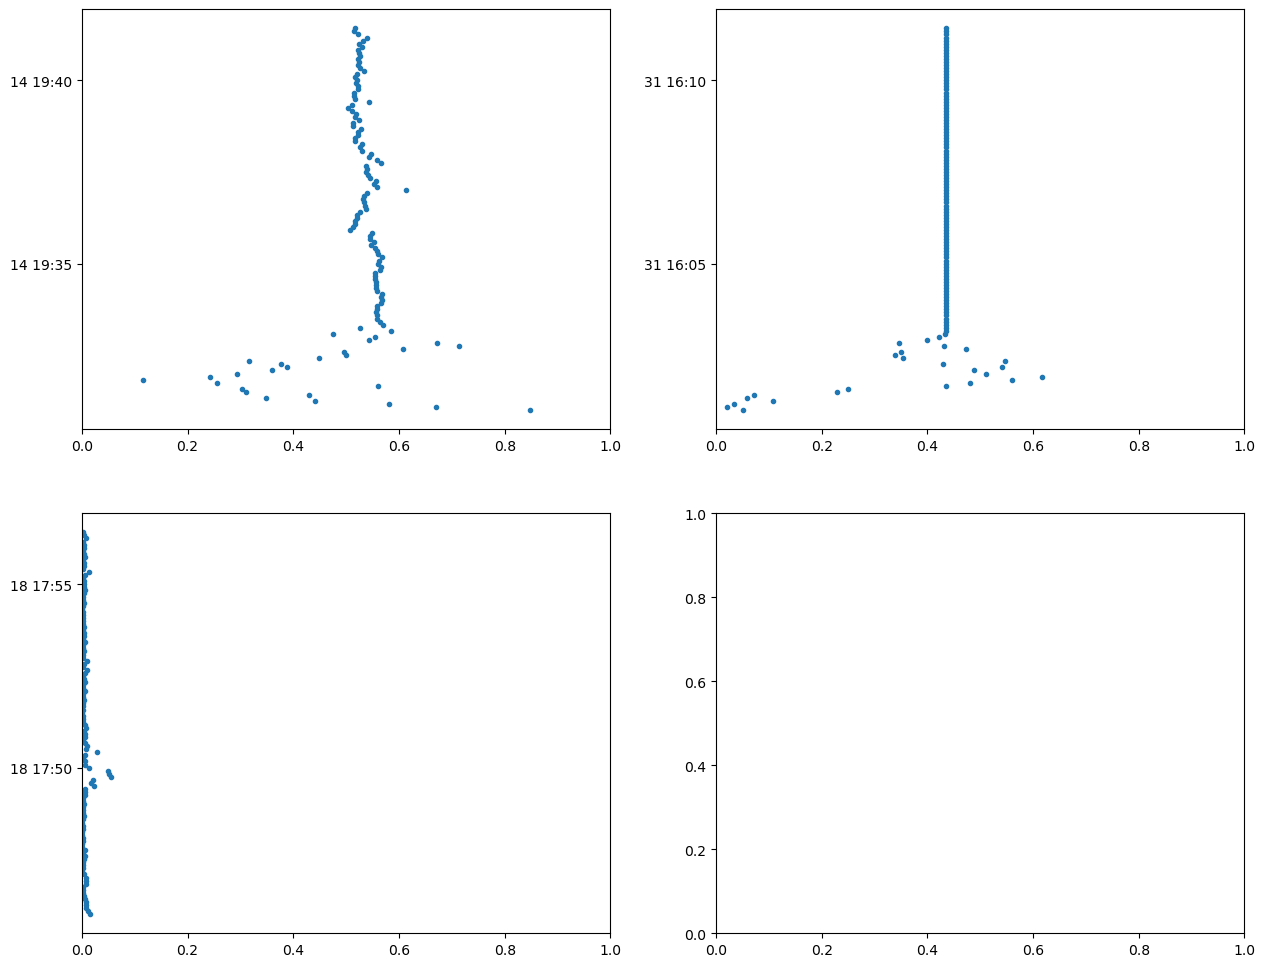

In [22]:
import matplotlib.pyplot as plt
plt.subplots(2, 2, figsize=(15, 12))
for i in range(3):
    plt.subplot(2,2,1+i)
    plt.plot(sleeps[i], dfs[i].loc[xAndIndex[i][1], 'timestamp'], '.')
    plt.xlim(0,1)

In [107]:
plt.subplots(2, 2, figsize=(15, 12))
res = [i for i in sleeps]
for i in range(3):
    plt.subplot(2,2,1+i)
    res[i] = sleeps[i]
    n = 4
    for _ in range(2):
        res[i] = np.convolve(res[i], [1./n]*n, 'same')
    plt.scatter(res[i][n:-n], dfs[i].loc[xAndIndex[i][1][n:-n], 'step'], s=0.5, c=res[i][n:-n] > 0.5)
    plt.xlim(0,1)
    plt.axvline(0.5, linewidth=0.25)
    plt.title(submission_files[i])

In [108]:
submission_files

['data\\test_sids\\038441c925bb.parquet',
 'data\\test_sids\\03d92c9f6f8a.parquet',
 'data\\test_sids\\0402a003dae9.parquet']

In [109]:
from postprocess import tabulate
s0 = tabulate(res[0][n:-n], xAndIndex[0][1][n:-n], dfs[0])
s0['series_id'] = "038441c925bb"
s0

,event,step,score,series_id
0,onset,32,1,038441c925bb


In [110]:
s1 = tabulate(res[1][n:-n], xAndIndex[1][1][n:-n], dfs[1])
s1['series_id'] = "03d92c9f6f8a"
s1

,event,step,score,series_id
0,onset,23,1,03d92c9f6f8a
1,wakeup,28,1,03d92c9f6f8a


In [118]:
submission_frame = pd.concat([s0, s1], ignore_index=True)
submission_frame = submission_frame.loc[:, ['series_id', 'step', 'event', 'score']]
submission_frame.index.name = "row_id"
submission_frame.to_csv('submission.csv')

In [119]:
submission_frame

,series_id,step,event,score
row_id,,,,
0,038441c925bb,32,onset,1
1,03d92c9f6f8a,23,onset,1
2,03d92c9f6f8a,28,wakeup,1


In [62]:
len(xAndIndex[2])

2

In [39]:
sid = test_sids[3]
sid

'18b61dd5aae8'

In [40]:
x, idx = model1min.getXandIndex(f'data\\sids\\{sid}.parquet')
x.shape, idx.shape

((495516, 2, 25), (495516,))

In [44]:
df = dataloader2.load_sid(f'data\\sids\\{sid}.parquet')
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
y = (df.loc[idx, 'activity']=='Sleeping').astype(int)
y.shape

(495516,)

In [42]:
preds = model1min.model(x)
preds.shape

TensorShape([495516, 2])

In [46]:
import visual
%matplotlib qt
anime = visual.scrol_predictions(preds[:, 1], y, df.loc[idx, 'timestamp'], pd.Timedelta(1, 'day'))

  0%|          | 0/992 [00:00<?, ?it/s]

In [50]:
importlib.reload(visual)

<module 'visual' from 'd:\\Projects\\ChildMindSleep\\visual.py'>

In [53]:
res = np.convolve(preds[:, 1], [1./12]*12, 'same')
for i in range(500):
    res = np.convolve(res, [1./12]*12, 'same')
res = np.convolve(res, [1./280]*280, 'same')
res = np.convolve(res, [1./280]*280, 'same')
anime = visual.scrol_predictions(res, y, df.loc[idx, 'timestamp'], pd.Timedelta(1, 'day'))

  0%|          | 0/992 [00:00<?, ?it/s]

In [54]:
res = np.convolve(res, [1./280]*280, 'same')
anime = visual.scrol_predictions(res, y, df.loc[idx, 'timestamp'], pd.Timedelta(1, 'day'))

  0%|          | 0/992 [00:00<?, ?it/s]